# Modeling & Feature Extraction

In [1]:
# loading libraries
import pandas as pd
import numpy as np
from numpy import where
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from contextlib import contextmanager
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
import autosklearn.classification
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, precision_recall_curve,plot_precision_recall_curve, average_precision_score
from sklearn import svm, manifold, decomposition, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix, average_precision_score, accuracy_score, f1_score
from tqdm import tqdm


/Users/rastkostojsin/opt/miniconda3/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


## Data Import (standardized data generated by data_normalization.ipynb) 

In [2]:
# load data (generated by 'data_normalization.ipynb')
df = pd.read_csv ('./data/standardized_data.csv')
# drop duplicate columns
df = df.drop(['age.1','dx.1','group.1','age.2','dx.2','group.2','age.3','dx.3','group.3','age.4','dx.4','group.4','age.5','dx.5','group.5',
         'age.6','dx.6','group.6','age.7','dx.7','group.7','age.8','dx.8','group.8','age.9','dx.9','group.9','age.10','dx.10','group.10',
         'age.11','dx.11','group.11','age.12','dx.12','group.12','age.13','dx.13','group.13','age.14','dx.14','group.14','age.15','dx.15','group.15',
         'age.16','dx.16','group.16','age.17','dx.17','group.17','age.18','dx.18','group.18','age.19','dx.19','group.19','age.20','dx.20','group.20',
         'age.21','dx.21','group.21','age.22','dx.22','group.22','age.23','dx.23','group.23','age.24','dx.24','group.24','age.25','dx.25','group.25',
         'age.26','dx.26','group.26','age.27','dx.27','group.27','age.28','dx.28','group.28','age.29','dx.29','group.29','age.30','dx.30','group.30',
         'age.31','dx.31','group.31','age.32','dx.32','group.32','age.33','dx.33','group.33','age.34','dx.34','group.34','age.35','dx.35','group.35',
         'age.36','dx.36','group.36','age.37','dx.37','group.37','age.38','dx.38','group.38','age.39','dx.39','group.39','age.40','dx.40','group.40',
         'age.41','dx.41','group.41','age.42','dx.42','group.42','age.43','dx.43','group.43','age.44','dx.44','group.44','age.45','dx.45','group.45',
         'age.46','dx.46','group.46','age.47','dx.47','group.47','age.48','dx.48','group.48'], axis=1)

In [3]:
# seperate train and test data
# train/test split determined in 'data_normalization.ipynb'
train_og = pd.DataFrame(df[df["group"] == "train"]).copy()
test_og = pd.DataFrame(df[df["group"] == "test"]).copy()

# change diagnosis from 1 (non alz) and 2 (alz) to 0 and 1 
# set diagnosis to output
y_train_og = pd.DataFrame(train_og["dx"])
y_train_og.loc[(train_og['dx'] == 1)] = 0
y_train_og.loc[(train_og['dx'] == 2)] = 1
y_test_og = pd.DataFrame(test_og["dx"])
y_test_og.loc[(test_og['dx'] == 1)] = 0
y_test_og.loc[(test_og['dx'] == 2)] = 1

# drop diagnosis, age, and group (train/test) from inputs
x_train_og = train_og.drop(['dx', 'age', 'group'], axis=1)
x_test_og = test_og.drop(['dx', 'age', 'group'], axis=1)

# recombine for full dataset
y_full_og = (pd.concat([y_train_og, y_test_og], axis=0))
x_full_og = (pd.concat([x_train_og, x_test_og], axis=0))

In [4]:
# initialize smote oversampler
oversample_smt = SMOTE(random_state=726)
# over sample alz scans
x_train_og_os, y_train_og_os = oversample_smt.fit_resample(x_train_og, y_train_og)

# full data sets for oversampled inputs
y_full_og_os = (pd.concat([y_train_og_os, y_test_og], axis=0))
x_full_og_os = (pd.concat([x_train_og_os, x_test_og], axis=0))

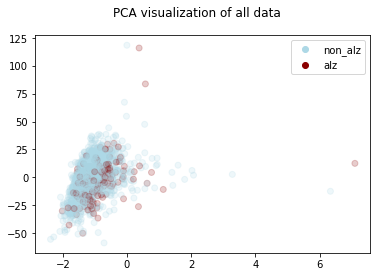

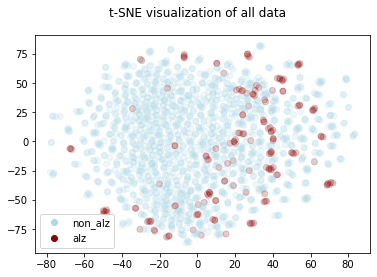

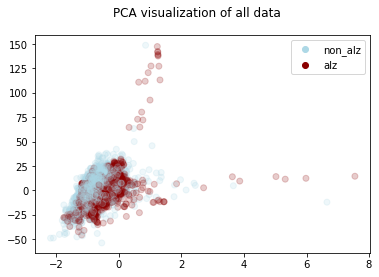

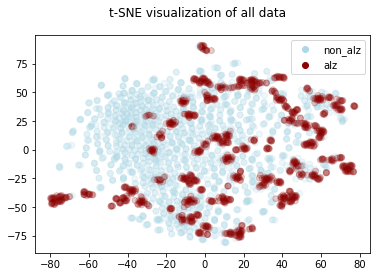

In [5]:
# pca of all data
pca = decomposition.PCA(n_components=2)
pca.fit(x_full_og)
Y = pca.transform(x_full_og)
# drop extream values
Y2 = np.c_[Y,y_full_og.values]
Y2 = Y2[Y2[:,0]<8]
# plot pca all data
colors = ['lightblue' if (i == 0) else 'darkred' for i in Y2[:, 2]]
fig = plt.figure(1)
fig.suptitle('PCA visualization of all data')
ax = fig.add_subplot(111)
ax.scatter(Y2[:, 0], Y2[:, 1], c=colors, alpha=0.2)
m1, = plt.plot(np.nan, np.nan, c='lightblue', linestyle='None', marker='o', label='non_alz', alpha=1)
m2, = plt.plot(np.nan, np.nan, c='darkred', linestyle='None', marker='o', label="alz", alpha=1)
plt.legend(handles=[m1, m2], loc='best')
plt.show()

# tsne of all data
tsne = manifold.TSNE(n_components=2, init='pca', random_state=726, n_iter=1500)
Y = tsne.fit_transform(x_full_og)
# drop extream values
Y2 = np.c_[Y,y_full_og.values]
Y2 = Y2[Y2[:,0] < 100]
# plot tsne of all data
colors = ['lightblue' if (i == 0) else 'darkred' for i in Y2[:, 2]]
fig = plt.figure(2)
fig.suptitle('t-SNE visualization of all data')
ax = fig.add_subplot(111)
ax.scatter(Y2[:, 0], Y2[:, 1], c=colors, alpha=0.2)
m1, = plt.plot(np.nan, np.nan, c='lightblue', linestyle='None', marker='o', label='non_alz', alpha=1)
m2, = plt.plot(np.nan, np.nan, c='darkred', linestyle='None', marker='o', label='alz', alpha=1)
plt.legend(handles=[m1, m2], loc='best')
plt.show()

# pca with smote oversampled alz scans
pca = decomposition.PCA(n_components=2)
pca.fit(x_full_og_os)
Y = pca.transform(x_full_og_os)
# drop extream values
Y2 = np.c_[Y,y_full_og_os.values]
Y2 = Y2[Y2[:,0]<8]
# plot pca w/oversampling
colors = ['lightblue' if (i == 0) else 'darkred' for i in Y2[:, 2]]
fig = plt.figure(1)
fig.suptitle('PCA visualization of all data')
ax = fig.add_subplot(111)
ax.scatter(Y2[:, 0], Y2[:, 1], c=colors, alpha=0.2)
m1, = plt.plot(np.nan, np.nan, c='lightblue', linestyle='None', marker='o', label='non_alz', alpha=1)
m2, = plt.plot(np.nan, np.nan, c='darkred', linestyle='None', marker='o', label="alz", alpha=1)
plt.legend(handles=[m1, m2], loc='best')
plt.show()

# tsne with smote oversampled alz scans
tsne = manifold.TSNE(n_components=2, init='pca', random_state=726, n_iter=1500)
Y = tsne.fit_transform(x_full_og_os)
# drop extream values
Y2 = np.c_[Y,y_full_og_os.values]
Y2 = Y2[Y2[:,0] < 100]
# plot
colors = ['lightblue' if (i == 0) else 'darkred' for i in Y2[:, 2]]
fig = plt.figure(2)
fig.suptitle('t-SNE visualization of all data')
ax = fig.add_subplot(111)
ax.scatter(Y2[:, 0], Y2[:, 1], c=colors, alpha=0.2)
m1, = plt.plot(np.nan, np.nan, c='lightblue', linestyle='None', marker='o', label='non_alz', alpha=1)
m2, = plt.plot(np.nan, np.nan, c='darkred', linestyle='None', marker='o', label='alz', alpha=1)
plt.legend(handles=[m1, m2], loc='best')
plt.show()

# Modeling

In [6]:
# Model definitions
# Logistic Regression Classification Model ---
mod_lgrg = LogisticRegression(max_iter=100000,solver="saga",penalty='elasticnet',l1_ratio=1, random_state = 726)

# Support Vector Classification Model --- 
mod_svc = svm.SVC(random_state=726,C=1.5,kernel='linear' ,probability = True,break_ties=True)

# Random Forest Classification Model ---
mod_rfc = RandomForestClassifier(random_state=726, max_features=0.2) 

# Multi-Layer Perceptron Classification Model ---
mod_mlp = MLPClassifier(random_state=726, activation = "tanh", alpha=1.8, hidden_layer_sizes=(150,), learning_rate = "adaptive")

# Gradient Boosted Tree Classification Model ---
mod_gbt = GradientBoostingClassifier(random_state=726, n_estimators=150, learning_rate=1.2, max_features=35, max_depth=8)

In [ ]:
# initialize k folds
n = 5
kf = StratifiedKFold(n_splits=n, shuffle=True)
# set inputs and outputs
X = x_train_og
y = y_train_og

# initialize validation accuracies & f1 scores for all models
valid_acc_gbt,valid_acc_lgrg, valid_acc_mlp, valid_acc_svc, valid_acc_rfc = [],[],[],[],[]
valid_f1s_gbt,valid_f1s_lgrg, valid_f1s_mlp, valid_f1s_svc, valid_f1s_rfc = [],[],[],[],[]

# loop through folds to calculate validation accuracies and f1 scores
for train_ix, validation_ix in tqdm(kf.split(X,y),total=n):
    # set training and validation set
    X_train, X_validation = X.iloc[train_ix], X.iloc[validation_ix]
    y_train, y_validation = y.iloc[train_ix], y.iloc[validation_ix]

    # set training set for oversampled population
    # oversampled only used where proveded better validation f1 scores (tree based models)
    X_train_over, y_train_over = oversample_smt.fit_resample(X_train, y_train)
    
    # logistic regression model ---
    # model fit and predict
    mod_lgrg.fit(X_train, y_train.to_numpy().ravel())
    pred_validation_lgrg = mod_lgrg.predict(X_validation)
    validation_acc_lgrg = accuracy_score(y_validation, pred_validation_lgrg)
    validation_f1s_lgrg = f1_score(y_validation, pred_validation_lgrg)

    # support vector model ---
    # model fit and predict
    mod_svc.fit(X_train, y_train.to_numpy().ravel())
    pred_validation_svc = mod_svc.predict(X_validation)
    validation_acc_svc = accuracy_score(y_validation, pred_validation_svc)
    validation_f1s_svc = f1_score(y_validation, pred_validation_svc)

    # random forest model ---
    # model fit and predict
    mod_rfc.fit(X_train_over, y_train_over.to_numpy().ravel())
    pred_validation_rfc = mod_rfc.predict(X_validation)
    validation_acc_rfc = accuracy_score(y_validation, pred_validation_rfc)
    validation_f1s_rfc = f1_score(y_validation, pred_validation_rfc)
    
    # multi-layer perceptron (fully connected neural net) model ---
    # model fit and predict
    mod_mlp.fit(X_train, y_train.to_numpy().ravel())
    pred_validation_mlp = mod_mlp.predict(X_validation)
    validation_acc_mlp = accuracy_score(y_validation, pred_validation_mlp)
    validation_f1s_mlp = f1_score(y_validation, pred_validation_mlp)
    
    # gradient boosted trees model ---
    # model fit and predict
    mod_gbt.fit(X_train_over, y_train_over.to_numpy().ravel())
    pred_validation_gbt = mod_gbt.predict(X_validation)
    validation_acc_gbt = accuracy_score(y_validation, pred_validation_gbt)
    validation_f1s_gbt = f1_score(y_validation, pred_validation_gbt)
    
    # store all models validation accuracies
    valid_acc_lgrg.append(validation_acc_lgrg)
    valid_acc_svc.append(validation_acc_svc)
    valid_acc_rfc.append(validation_acc_rfc)
    valid_acc_mlp.append(validation_acc_mlp)
    valid_acc_gbt.append(validation_acc_gbt)
    
    # store all models f1 scores accuracies
    valid_f1s_lgrg.append(validation_f1s_lgrg)
    valid_f1s_svc.append(validation_f1s_svc)
    valid_f1s_rfc.append(validation_f1s_rfc)
    valid_f1s_mlp.append(validation_f1s_mlp)
    valid_f1s_gbt.append(validation_f1s_gbt)


In [7]:
# re-fit models to full training set
# oversampled where validation f1score performance was better (tree based methods)
mod_lgrg.fit(x_train_og, y_train_og.to_numpy().ravel())
mod_svc.fit(x_train_og, y_train_og.to_numpy().ravel())
mod_rfc.fit(x_train_og_os, y_train_og_os.to_numpy().ravel())
mod_mlp.fit(x_train_og, y_train_og.to_numpy().ravel())
mod_gbt.fit(x_train_og_os, y_train_og_os.to_numpy().ravel())

GradientBoostingClassifier(learning_rate=1.2, max_depth=8, max_features=35,
                           n_estimators=150, random_state=726)

In [15]:
# show average validation accuracy
print("Average Validation Accuracy")
print("LGRG : ", np.mean(valid_acc_lgrg))
print("SVC  : ", np.mean(valid_acc_svc))
print("RFC  : ", np.mean(valid_acc_rfc))
print("MLP  : ", np.mean(valid_acc_mlp))
print("GBT  : ", np.mean(valid_acc_gbt))
# print("ABC  : ", np.mean(valid_acc_abc))

# show average validation f1 score
print("\nAverage Validation F1 Scores")
print("LGRG : ", np.mean(valid_f1s_lgrg))
print("SVC  : ", np.mean(valid_f1s_svc))
print("RFC  : ", np.mean(valid_f1s_rfc))
print("MLP  : ", np.mean(valid_f1s_mlp))
print("GBT  : ", np.mean(valid_f1s_gbt))
# print("ABC  : ", np.mean(valid_f1s_abc))

Average Validation Accuracy
LGRG :  0.9060748650197571
SVC  :  0.8944318764516034
RFC  :  0.9130576418423673
MLP  :  0.8897716647060598
GBT  :  0.9161584170361656

Average Validation F1 Scores
LGRG :  0.4665289954308059
SVC  :  0.4511924014888974
RFC  :  0.3521589037718069
MLP  :  0.4760234415213377
GBT  :  0.41217750257997937

Confusion Matrix (Training)
[[1158    0]
 [   1  129]]
[[1158    0]
 [   0  130]]
[[1158    0]
 [   0 1158]]
[[1158    0]
 [   1  129]]
[[1158    0]
 [   0 1158]]


# Model Evaluation

In [8]:
# use models to predict on test set
ns_probs = [0 for _ in range(len(y_test_og))]
lr_probs_lgrg = mod_lgrg.predict_proba(x_test_og)
lr_probs_lgrg = lr_probs_lgrg[:, 1]
lr_probs_svc = mod_svc.predict_proba(x_test_og)
lr_probs_svc = lr_probs_svc[:, 1]
lr_probs_rfc = mod_rfc.predict_proba(x_test_og)
lr_probs_rfc = lr_probs_rfc[:, 1]
lr_probs_mlp = mod_mlp.predict_proba(x_test_og)
lr_probs_mlp = lr_probs_mlp[:, 1]
lr_probs_gbt = mod_gbt.predict_proba(x_test_og)
lr_probs_gbt = lr_probs_gbt[:, 1]

# get each models accuracy and f1 scores
pred_test_lgrg = mod_lgrg.predict(x_test_og)
test_acc_lgrg = accuracy_score(y_test_og, pred_test_lgrg)
test_f1_lgrg = f1_score(y_test_og, pred_test_lgrg)

pred_test_svc = mod_svc.predict(x_test_og)
test_acc_svc = accuracy_score(y_test_og, pred_test_svc)
test_f1_svc = f1_score(y_test_og, pred_test_svc)

pred_test_rfc = mod_rfc.predict(x_test_og)
test_acc_rfc = accuracy_score(y_test_og, pred_test_rfc)
test_f1_rfc = f1_score(y_test_og, pred_test_rfc)

pred_test_mlp = mod_mlp.predict(x_test_og)
test_acc_mlp = accuracy_score(y_test_og, pred_test_mlp)
test_f1_mlp = f1_score(y_test_og, pred_test_mlp)

pred_test_gbt = mod_gbt.predict(x_test_og)
test_acc_gbt = accuracy_score(y_test_og, pred_test_gbt)
test_f1_gbt = f1_score(y_test_og, pred_test_gbt)

# pred_test_abc = mod_abc.predict(x_test_og)
# test_acc_abc = accuracy_score(y_test_og, pred_test_abc)
# test_f1_abc = f1_score(y_test_og, pred_test_abc)

# pred_test_asc = mod_asc.predict(x_test_og)
# test_acc_asc = accuracy_score(y_test_og, pred_test_asc)
# test_f1_asc = f1_score(y_test_og, pred_test_asc)

# print test accuracy
print("Average Test Accuracy")
print('LGRG : ', test_acc_lgrg)
print('SVC  : ', test_acc_svc)
print('RFC  : ', test_acc_rfc)
print('MLP  : ', test_acc_mlp)
print('GBT  : ', test_acc_gbt)
# print('ABC  : ', test_acc_abc)
# print('ABC  : ', test_acc_asc)

# print test f1 scores
print("\nAverage Test F1 Scores")
print('LGRG : ', test_f1_lgrg)
print('SVC  : ', test_f1_svc)
print('RFC  : ', test_f1_rfc)
print('MLP  : ', test_f1_mlp)
print('GBT  : ', test_f1_gbt)
# print('ABC  : ', test_f1_abc)
# print('ABC  : ', test_f1_asc)

# print test confusion matricies
print("\nConfusion Matrix (Test)")
print(confusion_matrix(y_test_og, mod_lgrg.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_svc.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_rfc.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_mlp.predict(x_test_og)))
print(confusion_matrix(y_test_og, mod_gbt.predict(x_test_og)))
# print(confusion_matrix(y_test_og, mod_abc.predict(x_test_og)))
# print(confusion_matrix(y_test_og, mod_asc.predict(x_test_og)))



Average Test Accuracy
LGRG :  0.9192546583850931
SVC  :  0.9130434782608695
RFC  :  0.937888198757764
MLP  :  0.9409937888198758
GBT  :  0.9503105590062112

Average Test F1 Scores
LGRG :  0.5806451612903226
SVC  :  0.6000000000000001
RFC  :  0.6153846153846154
MLP  :  0.6984126984126984
GBT  :  0.7037037037037038

Confusion Matrix (Test)
[[278  11]
 [ 15  18]]
[[273  16]
 [ 12  21]]
[[286   3]
 [ 17  16]]
[[281   8]
 [ 11  22]]
[[287   2]
 [ 14  19]]


Average Precision
LGRG :  0.5910873779519001
SVC  :  0.5737395479626145
RFC  :  0.66977392835003
MLP  :  0.6789907122198564
GBT  :  0.7317374740892872


ROC AUC
LGRG :  0.9302715738701897
SVC  :  0.9261822376009226
RFC  :  0.9101918842403272
MLP  :  0.9083569256579637
GBT  :  0.9102443116283946


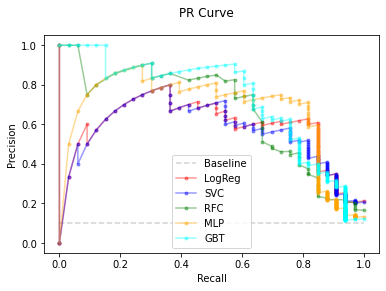

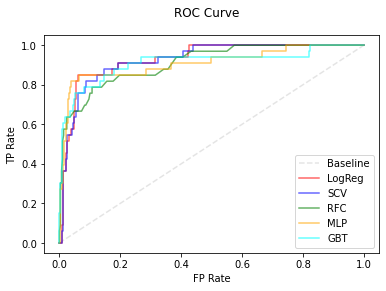

In [9]:
# averege test percision
average_precision_lgrg = average_precision_score(y_test_og, lr_probs_lgrg)
average_precision_svc = average_precision_score(y_test_og, lr_probs_svc)
average_precision_rfc = average_precision_score(y_test_og, lr_probs_rfc)
average_precision_mlp = average_precision_score(y_test_og, lr_probs_mlp)
average_precision_gbt = average_precision_score(y_test_og, lr_probs_gbt)
# average_precision_abc = average_precision_score(y_test_og, lr_probs_abc)
# average_precision_asc = average_precision_score(y_test_og, lr_probs_asc)

# average test roc auc
auc_lgrg = roc_auc_score(y_test_og, lr_probs_lgrg)
auc_svc = roc_auc_score(y_test_og, lr_probs_svc)
auc_rfc = roc_auc_score(y_test_og, lr_probs_rfc)
auc_mlp = roc_auc_score(y_test_og, lr_probs_mlp)
auc_gbt = roc_auc_score(y_test_og, lr_probs_gbt)
# auc_abc = roc_auc_score(y_test_og, lr_probs_abc)
# auc_asc = roc_auc_score(y_test_og, lr_probs_asc)

# no model auc
no_skill_pr = y_test_og.sum(axis =0) / len(y_test_og)
no_skill_auc = roc_auc_score(y_test_og, ns_probs)

# percision recall curve values 
precision_lgrg, recall_lgrg, thresholds_lgrg = precision_recall_curve(y_test_og, lr_probs_lgrg)
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_test_og, lr_probs_svc)
precision_rfc, recall_rfc, thresholds_rfc = precision_recall_curve(y_test_og, lr_probs_rfc)
precision_mlp, recall_mlp, thresholds_mlp = precision_recall_curve(y_test_og, lr_probs_mlp)
precision_gbt, recall_gbt, thresholds_gbt = precision_recall_curve(y_test_og, lr_probs_gbt)
# precision_abc, recall_abc, thresholds_abc = precision_recall_curve(y_test_og, lr_probs_abc)
# precision_asc, recall_asc, thresholds_asc = precision_recall_curve(y_test_og, lr_probs_asc)

# false postive/true positive rates for roc curve
no_skill_fpr, no_skill_tpr, _ = roc_curve(y_test_og, ns_probs)
fpr_lgrg, tpr_lgrg, _ = roc_curve(y_test_og, lr_probs_lgrg)
fpr_svc, tpr_svc, _ = roc_curve(y_test_og, lr_probs_svc)
fpr_rfc, tpr_rfc, _ = roc_curve(y_test_og, lr_probs_rfc)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_og, lr_probs_mlp)
fpr_gbt, tpr_gbt, _ = roc_curve(y_test_og, lr_probs_gbt)
# fpr_abc, tpr_abc, _ = roc_curve(y_test_og, lr_probs_abc)
# fpr_asc, tpr_asc, _ = roc_curve(y_test_og, lr_probs_asc)

# print average precision
print("Average Precision")
print("LGRG : ",(average_precision_lgrg))
print("SVC  : ",(average_precision_svc))
print("RFC  : ",(average_precision_rfc))
print("MLP  : ",(average_precision_mlp))
print("GBT  : ",(average_precision_gbt))
# print("ABC  : ",(average_precision_abc))
# print("ASC  : ",(average_precision_asc))

ns_auc = roc_auc_score(y_test_og, ns_probs)

# print roc auc
print("\n\nROC AUC")
print("LGRG : ",(auc_lgrg))
print("SVC  : ",(auc_svc))
print("RFC  : ",(auc_rfc))
print("MLP  : ",(auc_mlp))
print("GBT  : ",(auc_gbt))
# print("ABC  : ",(auc_abc))
# print("ABC  : ",(auc_asc))

# plot percision recall curve
fig = plt.figure(1)
fig.suptitle('PR Curve')
ax = fig.add_subplot(111)
plt.plot([0, 1], [no_skill_pr, no_skill_pr], linestyle='--', label='Baseline', color = "lightgrey")
plt.plot(recall_lgrg, precision_lgrg, marker='.', label='LogReg',color = "red", alpha = 0.4)
plt.plot(recall_svc, precision_svc, marker='.', label='SVC',color = "blue", alpha = 0.4)
plt.plot(recall_rfc, precision_rfc, marker='.', label='RFC',color = "green", alpha = 0.4)
plt.plot(recall_mlp, precision_mlp, marker='.', label='MLP',color = "orange", alpha = 0.4)
plt.plot(recall_gbt, precision_gbt, marker='.', label='GBT',color = "cyan", alpha = 0.4)
# plt.plot(recall_abc, precision_abc, marker='.', label='ABC',color = "purple", alpha = 0.4)
# plt.plot(recall_asc, precision_asc, marker='.', label='ASC',color = "yellow", alpha = 0.4)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# plot ROC curve
fig = plt.figure(2)
fig.suptitle('ROC Curve')
ax = fig.add_subplot(111)
plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='Baseline', color = "lightgrey", alpha = 0.6)
plt.plot(fpr_lgrg, tpr_lgrg, marker='', label='LogReg', color = "red", alpha = 0.6)
plt.plot(fpr_svc, tpr_svc, marker='', label='SCV', color = "blue", alpha = 0.6)
plt.plot(fpr_rfc, tpr_rfc, marker='', label='RFC', color = "green", alpha = 0.6)
plt.plot(fpr_mlp, tpr_mlp, marker='', label='MLP', color = "orange", alpha = 0.6)
plt.plot(fpr_gbt, tpr_gbt, marker='', label='GBT', color = "cyan", alpha = 0.6)
# plt.plot(fpr_abc, tpr_abc, marker='', label='ABC', color = "purple", alpha = 0.6)
# plt.plot(fpr_asc, tpr_asc, marker='', label='ASC', color = "yellow", alpha = 0.6)
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend()

# Feature Importance

In [10]:
# feature importance function 
# get feature importance by tracking changes in f1 scores with random permutations of feature
def get_feature_importance(j, n, y_test, x_test, test_pred, model):
    s = f1_score(y_test, test_pred) # baseline score
    total = 0.0
    # loop through number of random permutations defined
    for i in range(n):
        # get a random permutation of the set feature
        perm = np.random.permutation(range(x_test.to_numpy().shape[0]))
        X_test_ = x_test.to_numpy().copy()
        X_test_[:, j] = x_test.to_numpy()[perm, j]
        # re-predict with new input (permutated feature of interest)
        y_pred_ = model.predict(X_test_)
        # calculate f1 score and add to running total
        s_ij = f1_score(y_test, y_pred_)
        total += s_ij
    # return the average difference in f1 score
    return s - total / n

In [11]:
# set importances to coeficients / feature importances 
importance_lgrg = mod_lgrg.coef_[0]
importance_svc = mod_svc.coef_[0]
importance_rfc = mod_rfc.feature_importances_
importance_gbt = mod_gbt.feature_importances_
# importance_abc = mod_abc.feature_importances_

# ordering by absolute difference
fimp_lgrg = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}),
                       pd.DataFrame(importance_lgrg).rename(columns={0:"lgrg_importance"})),axis=1)
fimp_lgrg["absolute importance"] = np.abs(pd.to_numeric(fimp_lgrg["lgrg_importance"]))
fimp_lgrg = fimp_lgrg.drop("absolute importance",axis=1)

# ordering by absolute difference
fimp_svc = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}),
                      pd.DataFrame(importance_svc).rename(columns={0:"svc_importance"})),axis=1)
fimp_svc["absolute importance"] = np.abs(pd.to_numeric(fimp_svc["svc_importance"]))
fimp_svc = fimp_svc.drop("absolute importance",axis=1)

fimp_rfc = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}), 
                      pd.DataFrame(importance_rfc).rename(columns={0:"rfc_importance"})),axis=1)

fimp_gbt = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}), 
                      pd.DataFrame(importance_gbt).rename(columns={0:"gbt_importance"})),axis=1)

# fimp_abc = pd.concat((pd.DataFrame(x_full_og.columns).rename(columns={0:"feature"}), 
#                       pd.DataFrame(importance_abc).rename(columns={0:"abc_importance"})),axis=1)

# calculating feature importance for fully connected neural net via feature permuation
n = 200 #200 permutations : 42min
f_mlp = []

# loop through all features
for j in tqdm(range(x_test_og.shape[1])): 
    # get permutation average difference in f1 scores
    f_j = get_feature_importance(j, n, y_test_og, x_test_og, pred_test_mlp, mod_mlp)
    f_mlp.append(f_j)

fimp_mlp = pd.DataFrame({'feature': list(x_test_og.columns),'mlp_importance': f_mlp})

100%|██████████| 1519/1519 [42:02<00:00,  1.66s/it] 


,feature,mlp_importance
1350,b44_V18,0.016158
44,b2_V14,0.015799
477,b16_V13,0.012899
18,b1_V19,0.011772
7,b1_V8,0.009198


In [43]:
# creating f1 scores dataframe
f1_scores = {'models': ['lgrg','svc','rfc','mlp','gbt'], 
             'f1scores': [test_f1_lgrg, test_f1_svc, test_f1_rfc,
                         test_f1_mlp, test_f1_gbt]}
f1_scores = pd.DataFrame(data=f1_scores).set_index('models')
f1_tot = f1_scores['f1scores'].sum()
# weighting f1 scores
f1_scores_ratio = f1_scores['f1scores']/f1_tot.sum()

# joining feature importances together
feature_importances = fimp_lgrg.set_index('feature').join(
    fimp_svc.set_index('feature')).join(
    fimp_rfc.set_index('feature')).join(
    fimp_mlp.set_index('feature')).join(
    fimp_gbt.set_index('feature'))

# setting bundle measure as index
feature_importances['bundle_measure'] = feature_importances.index

new = feature_importances['bundle_measure'].str.split("_", n = 1, expand = True)
  
# making separate bundle name column from new data frame
feature_importances["bundle"]= new[0]
  
# making separate measure name column from new data frame
feature_importances["measure"]= new[1]

# loading measure and bundle dictionaries
meas_dict = pd.read_csv ('./data/measures_dict.csv').set_index("m#")
bund_dict = pd.read_csv ('./data/bundles_dict.csv').set_index("b#")

# joining full bundle and measure names to feature importances
feature_importances = pd.merge(feature_importances, meas_dict, left_on='measure', right_on='m#')
feature_importances = pd.merge(feature_importances, bund_dict, left_on='bundle', right_on='b#')

# normalizing columns (0-1)
cols_to_norm = ['lgrg_importance','svc_importance', 'rfc_importance','mlp_importance','gbt_importance']
feature_importances[cols_to_norm] = feature_importances[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# weighting the normalized features by the f1 score ratios
feature_importances.reset_index(drop=True, inplace=True)
feature_importances["lgrg_importance"] = feature_importances["lgrg_importance"]*f1_scores_ratio[0]
feature_importances["svc_importance"] = feature_importances["svc_importance"]*f1_scores_ratio[1]
feature_importances["rfc_importance"] = feature_importances["rfc_importance"]*f1_scores_ratio[2]
feature_importances["mlp_importance"] = feature_importances["mlp_importance"]*f1_scores_ratio[3]
feature_importances["gbt_importance"] = feature_importances["gbt_importance"]*f1_scores_ratio[4]

# saving normalized f1 score weighted feature importances
feature_importances.to_csv('./feature_imps/feature_importances.csv')